# Import Libraries and Load Data

In [35]:
# core libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# plotting settings
%matplotlib inline

# dictionary to provide to plotly to get custom settings
plotly_styles = dict(
    font_family="DejaVuSansMono Nerd Font",
    template="none",
    title={
        "x": 0.05,
        # basically, what part of the title to put at position "x"
        "xanchor": "left"
    }
)

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# for nice outputs:
from rich.console import Console
console=Console()

In [36]:
nil_daily_rentals = pd.read_csv("../data/bikemi_csv/nil_daily_outflow.csv", parse_dates=[0], index_col=[0])
nil_daily_rentals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32120 entries, 2019-01-01 to 2019-12-31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nil_name  32120 non-null  object
 1   count     32120 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 752.8+ KB


# Data Preprocessing

## Pivot to Wide Format

Let's start by pivoting the data to a wide format, to obtain as many time series as there are neighbourhoods in Milan:

In [37]:
nil_rentals_pivot = nil_daily_rentals.pivot(columns="nil_name", values="count")
nil_rentals_pivot

nil_name,Adriano,Affori,Assiano,Baggio - Q.Re Degli Olmi - Q.Re Valsesia,Bande Nere,Barona,Bicocca,Bovisa,Bovisasca,Brera,...,Stephenson,Taliedo - Morsenchio - Q.Re Forlanini,Tibaldi,Tre Torri,Trenno,Triulzo Superiore,Umbria - Molise - Calvairate,Vigentino - Q.Re Fatima,Villapizzone - Cagnola - Boldinasco,Xxii Marzo
giorno_partenza,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0,0,0,0,0,0,4,6,0,54,...,0,0,0,0,0,0,0,0,4,25
2019-01-02,0,0,0,0,0,0,23,24,0,237,...,0,0,0,0,0,0,0,0,18,93
2019-01-03,0,0,0,0,0,0,26,26,0,276,...,0,0,0,0,0,0,0,0,28,107
2019-01-04,0,0,0,0,0,0,27,31,0,294,...,0,0,0,0,0,0,0,0,19,103
2019-01-05,0,0,0,0,0,0,10,17,0,175,...,0,0,0,0,0,0,0,0,20,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0,0,0,0,5,0,11,8,0,218,...,0,0,0,0,0,0,13,0,25,82
2019-12-28,0,0,0,0,6,0,8,5,0,140,...,0,0,0,0,0,0,12,0,25,56
2019-12-29,0,0,0,0,5,0,6,4,0,73,...,0,0,0,0,0,0,13,0,9,34


There appear to be quite many zeros in our dataset, i.e. the matrix seems quite sparse. We can count them:

In [38]:
empy_cols = [col for col in nil_rentals_pivot.columns if nil_rentals_pivot[col].sum() == 0]
console.print(f"There are {len(empy_cols)} empty columns")

There are 46 empty columns

## Remove Neighbourhoods with no Stations

Let's get rid of the columns with only zeros:


In [39]:
nil_rentals_multivariate = nil_rentals_pivot.drop(axis=1, columns=[col for col in empy_cols])

nil_rentals_multivariate

nil_name,Bande Nere,Bicocca,Bovisa,Brera,Buenos Aires - Porta Venezia - Porta Monforte,Citta' Studi,De Angeli - Monte Rosa,Dergano,Duomo,Farini,...,Portello,Pta Romana,Q.Re Gallaratese - Q.Re San Leonardo - Lampugnano,Qt 8,Sarpi,Scalo Romana,Stazione Centrale - Ponte Seveso,Umbria - Molise - Calvairate,Villapizzone - Cagnola - Boldinasco,Xxii Marzo
giorno_partenza,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0,4,6,54,74,44,17,7,99,2,...,14,17,0,1,43,1,57,0,4,25
2019-01-02,0,23,24,237,300,105,54,23,545,31,...,43,90,1,4,123,21,233,0,18,93
2019-01-03,0,26,26,276,340,116,62,22,601,31,...,40,107,0,2,178,16,225,0,28,107
2019-01-04,0,27,31,294,362,129,61,25,633,31,...,48,93,0,4,193,19,211,0,19,103
2019-01-05,0,10,17,175,355,96,39,17,416,23,...,41,85,0,0,173,11,110,0,20,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,5,11,8,218,279,79,54,10,445,17,...,35,75,1,4,162,15,137,13,25,82
2019-12-28,6,8,5,140,194,55,44,6,285,13,...,25,47,0,2,110,10,97,12,25,56
2019-12-29,5,6,4,73,129,36,30,6,171,6,...,17,38,0,1,84,5,72,13,9,34


# Correlations Across Neighbourhoods

The data seems to be more manageable now. Yet, there might still be some cleaning to do: some columns might still display too low of a count. Let's try to eyeball them from a `corrplot`:

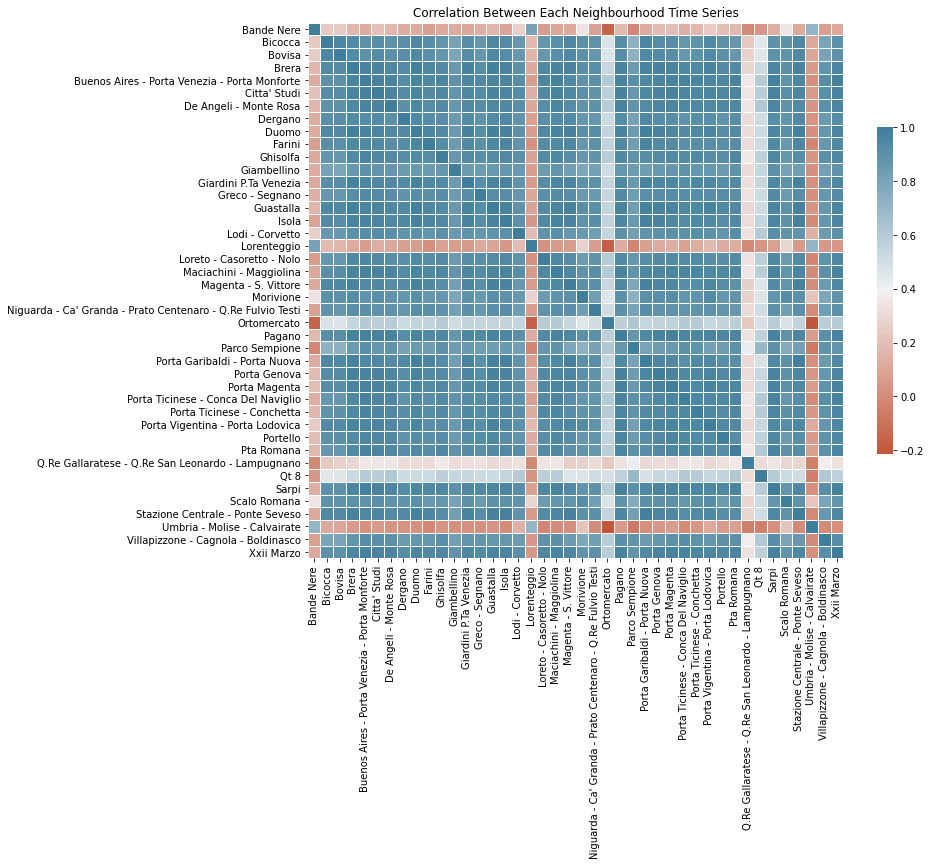

In [40]:
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(
    nil_rentals_multivariate.corr(),
    ax = ax,
    square=True,
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    linewidths=.5,
    cbar_kws={"shrink": .5}) \
        .set(
            xlabel="",
            ylabel="",
            title="Correlation Between Each Neighbourhood Time Series");

Or exploit an interactive one to view correlations with greater detail:

In [41]:
px.imshow(
    nil_rentals_multivariate.corr(),
    width=1000, height=1000,
    color_continuous_scale=px.colors.sequential.RdBu,
    labels={"x":"", "y":""}
    ) \
        .update_layout(
            title_text="Correlation Across Neighbourhoods",
            font_family="Consolas"
        )

In [ ]:
nil_value_counts = pd.DataFrame(nil_rentals_multivariate.value_counts())\
    .reset_index() \
    .rename(columns={"count": "rentals", 0: "frequency"}) \
    .assign(pct_null = lambda x: np.around(x["frequency"] / 365, decimals=3)) \
    .sort_values("pct_null")

nil_value_counts.query("pct_null = 1")